# Consumer prices on Amazon's marketplace

This notebook serves as a Proof of Concept (PoC) for the collection of Amazon's history of consumer prices (`prices` henceforth).

## Housekeeping

Useful imports.

In [1]:
import os

In [2]:
from bs4 import BeautifulSoup

In [3]:
import numpy as np
import pandas as pd

In [4]:
from mimetypes import guess_extension
from seleniumwire import webdriver

In [5]:
from PIL import Image

In [6]:
import matplotlib.pyplot as plt

In [7]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = "/usr/local/Cellar/tesseract/5.2.0/bin/tesseract"

In [8]:
import re

In [9]:
from datetime import datetime

Example of product with which we work in this notebook.

In [10]:
sku_reference = "B000CRBEJ2"

Country taken as example in this notebook.

In [11]:
# France
country = "fr"

Folder where we store the price history chart.

In [12]:
temp_folder = 'temp'

## Fetching the price history chart

In [501]:
# Create a new instance of the Chrome driver
driver = webdriver.Chrome()

In [502]:
# Creating the URL to price history chart on camelcamelcamel

height = 6200
width = 12000

base = "https://charts.camelcamelcamel.com/"
url_to_img = base + country + "/"
url_to_img += sku_reference + "/"
url_to_img += 'new.png'

url_to_img += f"?force=1&zero=0&w={width}&h={height}&desired=false&legend=1&ilt=1&tp=all&fo=0&lang=fr_FR"

print("URL to the price history chart:", url_to_img)

URL to the price history chart: https://charts.camelcamelcamel.com/fr/B000CRBEJ2/new.png?force=1&zero=0&w=12000&h=6200&desired=false&legend=1&ilt=1&tp=all&fo=0&lang=fr_FR


In [503]:
# Downloading the image

driver.get(url_to_img)

In [504]:
requests = pd.Series(driver.requests)

request = requests[
    requests.map(
        lambda request: guess_extension(
            request.response.headers['Content-Type'].split(';')[0].strip()
        ) == ".png"
    )
].iloc[0]

file_name = os.path.join(temp_folder, sku_reference) + '.png'

with open(file_name, 'wb') as file:
    file.write(request.response.body)

## Fetching additional information

In [505]:
url_to_info = f"https://{country}.camelcamelcamel.com/product/{sku_reference}?context=search"

In [506]:
driver.get(url_to_info)

In [507]:
soup = BeautifulSoup(driver.page_source, "html.parser")

In [508]:
min_price = price_history_summary.set_index(
    'Type de prix'
).loc[
    'Amazon', 'Le plus bas jamais atteint *'
]

min_price = float(min_price[:min_price.find('€')].replace(',', '.'))

In [509]:
max_price = price_history_summary.set_index(
    'Type de prix'
).loc[
    'Amazon', 'Le plus élevé de tous les temps *'
]

max_price = float(max_price[:max_price.find('€')].replace(',', '.'))

In [510]:
product_data = pd.read_html(str(soup.find_all(class_='product_fields')[0]))[0]

In [513]:
product_data.set_index(0).T

,Groupe de produits,Catégorie,Fabricant,Modèle,Locale,Prix de vente,EAN,UPC,SKU,Dernier scan de mise à jour,Dernier suivi
1,Luggage,Target,Eastpak,Padded Pak'r,FR,"55,00€",540055216802,032546446202,B000CRBEJ2,il y a13 heures,27 jours


## Deducing price history from the graph

In [98]:
img = Image.open(os.path.join(temp_folder, sku_reference + '.png'))
img_array = np.array(img)

In [153]:
# Pixels that have the RGB code for the maximum price
y, x = np.where(np.all(img_array == [194, 68, 68, 255], axis=2))

# Average y-coordinate of the left-most pixels with this RGB code
avg_y_coord_max = img_array.shape[0] - y[np.where(x == min(x))].mean()

# Minimum x-coordinate of the pixels with this RGB code outside of the horizontal dashed line
outside_chart_x_coord = min(
    x[
        np.where(
            ~np.isin(y, y[np.where(x == min(x))])
        )
    ]
)

print("Average y-coordinate (from bottom to top of the image):", avg_y_coord_max)
print("Writing on RHS of the graph start at x-coordinate:", outside_chart_x_coord)

Average y-coordinate (from bottom to top of the image): 2070.5
Writing on RHS of the graph start at x-coordinate: 3122


In [154]:
# Pixels that have the RGB code for the minimum price
y, x = np.where(np.all(img_array == [119, 195, 107, 255], axis=2))

# Average y-coordinate of the left-most pixels with this RGB code
avg_y_coord_min = img_array.shape[0] - y[np.where(x == min(x))].mean()

# Minimum x-coordinate of the pixels with this RGB code outside of the horizontal dashed line
outside_chart_x_coord_bis = min(
    x[
        np.where(
            ~np.isin(y, y[np.where(x == min(x))])
        )
    ]
)

if outside_chart_x_coord != outside_chart_x_coord_bis:
    raise Exception('Writings on RHS of the graph seem misaligned.')

print("Average y-coordinate (from bottom to top of the image):", avg_y_coord_min)
print("Writing on RHS of the graph start at x-coordinate:", outside_chart_x_coord_bis)

Average y-coordinate (from bottom to top of the image): 356.5
Writing on RHS of the graph start at x-coordinate: 3122


In [155]:
y, x = np.where(np.all(img_array == [99, 168, 94, 255], axis=2))

x_axis_coords = []
avg_y_coords = []

for x_axis_coord in np.unique(x):
    if x_axis_coord < outside_chart_x_coord_bis:
        y_coords = y[np.where(x == x_axis_coord)]
        y_coords = y_coords[y_coords < 2400 - avg_y_coord_min].copy()
        
        avg_y_coord = img_array.shape[0] - y_coords.mean()
        
        avg_y_coords.append(avg_y_coord)
        x_axis_coords.append(x_axis_coord)
        
    else:
        continue
    
x_axis_coords = np.array(x_axis_coords)
avg_y_coords = np.array(avg_y_coords)

In [192]:
prices = (
    min_price
    + (avg_y_coords - avg_y_coord_min) / (avg_y_coord_max - avg_y_coord_min) * (max_price - min_price)
)

In [205]:
price_history = pd.DataFrame([x_axis_coords, prices], index=['x_axis_coord', 'price']).T
price_history.head()

,x_axis_coord,price
0,70.0,37.971785
1,71.0,37.971785
2,72.0,37.971785
3,73.0,37.971785
4,74.0,37.971785


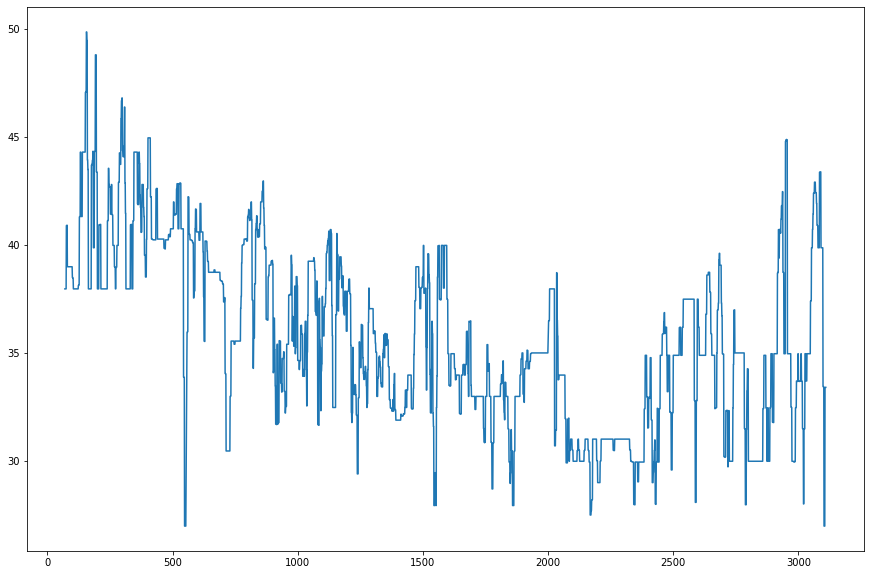

In [210]:
# Checking the shape of the price history

plt.figure(figsize=(15, 10))
plt.plot(x_axis_coords, prices)

plt.show()

## Determining the start and end dates on the x-axis of the graph

In [357]:
text = pytesseract.image_to_string(img, lang='eng')
print(text)

Amazon Basics - Cable HDMI A 2.0 vers HDMI A haute vitesse Ultra HD, supportant les formats 3D et avec canal de retour audio, 1,8 m, noir

€15 9

€7,44

€0 + T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T ™
16 Apr Jul Oct ‘17 Apr Jul Oct ‘18 Apr Jul Oct ‘19 Apr Jul Oct ‘20 Apr Jul Oct ‘21 Apr Jul Oct ‘22 Apr Jul Oct ‘23 Apr Jul Oct
Price type Lowest Highest Current
i Amazon €4,49 (Apr 8, 2019) €11,88 (Oct 3, 2017) €7,44 (Nov 29, 2023)

© camelcamelcamel.com - https://3cmls.co/FR/B014I8SSDO


In [372]:
text_extract = text[text.rfind('T T T'):text.rfind('Price type')]
print(text_extract)

T T T ™
16 Apr Jul Oct ‘17 Apr Jul Oct ‘18 Apr Jul Oct ‘19 Apr Jul Oct ‘20 Apr Jul Oct ‘21 Apr Jul Oct ‘22 Apr Jul Oct ‘23 Apr Jul Oct



In [359]:
months = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

months_idx = []

for month in months:
    months_idx.append(
        text_extract.find(month) if text_extract.find(month) > 0 else np.nan
    )
    
months_idx = np.array(months_idx)

In [360]:
first_month = months[np.where(months_idx == np.nanmin(months_idx))][0]
first_month

'Apr'

In [361]:
months_idx_right = []

for month in months:
    months_idx_right.append(
        text_extract.rfind(month) if text_extract.rfind(month) > -1 else np.nan
    )
    
months_idx_right = np.array(months_idx_right)

In [362]:
last_month = months[np.where(months_idx_right == np.nanmax(months_idx_right))][0]
last_month

'Oct'

In [366]:
first_year = 2000 + int(re.findall(r'\d\d', text_extract)[0])
last_year = 2000 + int(re.findall(r'\d\d', text_extract)[-1])

In [368]:
if text_extract.find(str(first_year - 2000)) < text_extract.find(first_month):
    first_month = 'Jan'

In [373]:
if text_extract.rfind(str(last_year - 2000)) > text_extract.rfind(last_month):
    last_month = 'Jan'

In [375]:
print('First date:', first_month, first_year)
print('Last date:', last_month, last_year)

First date: Jan 2016
Last date: Oct 2023


## Determining the last date from additional data

In [401]:
last_date_clean = datetime.strptime(
    price_history_summary.set_index(
        'Type de prix'
    ).loc[
        'Amazon', 'Actuel +'
    ].split('(')[1].strip(')').replace('.', ''), 
    "%d %b %Y"
)

## Converting x-coordinates into a time series

In [402]:
first_date = datetime.strptime(' '.join([first_month, str(first_year)]), "%b %Y")
last_date = datetime.strptime(' '.join([last_month, str(last_year)]), "%b %Y")

In [403]:
time_delta = last_date_clean - first_date

In [410]:
hour_increment = time_delta.days * 24 / len(price_history)

In [415]:
all_time_deltas = pd.to_timedelta(price_history.reset_index()['index'] * hour_increment, unit='hours')

In [417]:
price_history['date'] = all_time_deltas + first_date

In [419]:
price_history = price_history.drop(columns=['x_axis_coord'])

In [420]:
price_history

,price,date
0,37.971785,2016-01-01 00:00:00.000000000
1,37.971785,2016-01-01 23:02:33.191487600
2,37.971785,2016-01-02 22:05:06.382978800
3,37.971785,2016-01-03 21:07:39.574466400
4,37.971785,2016-01-04 20:10:12.765957600
...,...,...
3003,26.972952,2023-11-23 04:47:14.042554800
3004,33.407270,2023-11-24 03:49:47.234042400
3005,33.407270,2023-11-25 02:52:20.425533600
3006,33.407270,2023-11-26 01:54:53.617021200


## Debugging

In [46]:
start_end_dates = {'amazon': {}}.copy()

paths_to_charts = {
    'amazon': '/Users/Paul-Emmanuel/Desktop/PhD/3_DST_incidence/dst_incidence/notebooks/temp/B000CRBEJ2_amazon.png',
    'new': '/Users/Paul-Emmanuel/Desktop/PhD/3_DST_incidence/dst_incidence/notebooks/temp/B000CRBEJ2_new.png'
}

In [49]:
img = Image.open(paths_to_charts['new'])

In [51]:
img_array = np.array(img)

In [53]:
y, x = np.where(np.all(img_array == (8,52,190, 255), axis=2))

In [54]:
y

array([], dtype=int64)

In [58]:
y, x = np.where(img_array[0:-1, 0:-1, 2] > img_array[0:-1, 0:-1, 0] * 10)

In [62]:
img_array.shape

(2400, 3200, 4)

In [65]:
img_array[1689, 836]

array([255, 255, 255, 255], dtype=uint8)

In [64]:
img_array[0:, 0:, 2]

(2400, 3200)

In [69]:
y, x = np.where(~np.all(img_array == (255,255,255, 255), axis=2))

In [90]:
pixels = pd.DataFrame(img_array.reshape(img_array.shape[0] * img_array.shape[1], 4))

In [91]:
pixels.head()

,0,1,2,3
0,255,255,255,143
1,255,255,255,191
2,255,255,255,191
3,255,255,255,191
4,255,255,255,191


In [96]:
pixels.value_counts().head(10)

0    1    2    3  
255  255  255  255    5609409
251  251  251  255    1105430
0    51   204  255     264924
245  245  245  255     263583
252  252  252  255     174176
254  254  254  255     110381
253  253  253  255      61559
221  221  221  255      29428
51   51   51   255      20873
255  255  255  191      10324
dtype: int64

In [87]:
pixels = pixels.drop_duplicates()

In [88]:
pixels_restr = pixels[pixels[[0, 1, 2]].mean(axis=1) != 255].copy()

In [89]:
pixels_restr[pixels_restr[2] > pixels_restr[0]].drop_duplicates()

,0,1,2,3
846316,0,51,204,255
1535955,235,239,251,255
1535956,125,151,229,255
1535957,48,89,214,255
1535958,12,61,206,255
...,...,...,...,...
1587156,137,161,231,255
1587157,52,93,214,255
1587179,242,245,252,255
1587180,126,152,229,255


In [59]:
img_array[np.where(img_array[0:-1, 0:-1, 2] > img_array[0:-1, 0:-1, 0] * 10)]

array([[255, 255, 255, 143],
       [255, 255, 255, 191],
       [255, 255, 255, 191],
       ...,
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255]], dtype=uint8)

In [52]:
(8,52,190, 255)

array([[[255, 255, 255, 143],
        [255, 255, 255, 191],
        [255, 255, 255, 191],
        ...,
        [255, 255, 255, 191],
        [255, 255, 255, 191],
        [255, 255, 255, 143]],

       [[255, 255, 255, 191],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 191]],

       [[255, 255, 255, 191],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 191]],

       ...,

       [[255, 255, 255, 191],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 191]],

       [[255, 255, 255, 191],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 191]],

       [[255

## Example of price history inference

In [111]:
path_to_price_history = """
    /Users/Paul-Emmanuel/Desktop/PhD/3_DST_incidence/dst_incidence/dst_incidence/data/prices/price_history.csv
"""
path_to_price_history_summary = """
    /Users/Paul-Emmanuel/Desktop/PhD/3_DST_incidence/dst_incidence/dst_incidence/data/prices/price_history_summary.csv
"""

In [112]:
price_history_summary = pd.read_csv(path_to_price_history_summary.strip('\n '))

In [113]:
price_history_summary

,sku,country,unit,seller,min_price,min_price_date,max_price,max_price_date,current_price,current_price_date,average_price
0,B000CRBEJ2,fr,€,amazon,23.38,2020-06-22,54.8,2023-05-29,38.57,2023-12-03,39.38
1,B000CRBEJ2,fr,€,new,8.00,2017-07-16,50.0,2018-10-27,NaN,NaN,36.98
2,B000CRBEJ2,fr,€,used,16.00,2018-10-20,125.0,2018-09-20,NaN,NaN,34.43


In [99]:
price_history = pd.read_csv(path_to_price_history.strip('\n '))

In [105]:
price_history['date'] = pd.to_datetime(price_history['date'])

In [116]:
sku = price_history['sku'].unique()[0]
seller = 'amazon'

In [117]:
price_history_summary = price_history_summary[
    np.logical_and(
        price_history_summary['sku'] == sku,
        price_history_summary['seller'] == seller
    )
].copy()
price_history = price_history[
    np.logical_and(
        price_history['sku'] == sku,
        price_history['seller'] == seller
    )
].copy()

In [118]:
price_history.head()

,price,sku,country,unit,seller,date
0,37.971785,B000CRBEJ2,fr,€,amazon,2015-07-01 00:00:00.000000
1,37.971785,B000CRBEJ2,fr,€,amazon,2015-07-02 00:33:01.914894
2,37.971785,B000CRBEJ2,fr,€,amazon,2015-07-03 01:06:03.829788
3,37.971785,B000CRBEJ2,fr,€,amazon,2015-07-04 01:39:05.744682
4,37.971785,B000CRBEJ2,fr,€,amazon,2015-07-05 02:12:07.659576


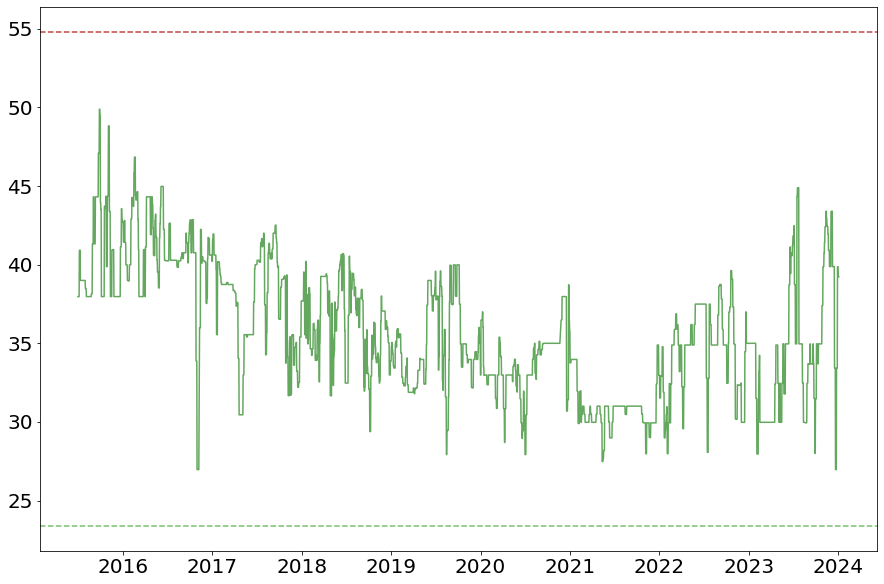

In [140]:
plt.figure(figsize=(15, 10))
plt.plot(price_history['date'], price_history['price'], color=np.array((99, 168, 94, 255)) / 255)
plt.axhline(
    price_history_summary.loc[price_history_summary.index[0], 'min_price'],
    linestyle='--', color=np.array((119, 195, 107, 255)) / 255
)
plt.axhline(
    price_history_summary.loc[price_history_summary.index[0], 'max_price'],
    linestyle='--', color=np.array((194, 68, 68, 255)) / 255
)
plt.rcParams.update({'font.size': 20})
plt.savefig(
    "/Users/Paul-Emmanuel/Dropbox/Applications/Overleaf/DST Incidence/static/price_history_inference_example.png",
    bbox_inches='tight'
)
plt.show()

<Figure size 432x288 with 0 Axes>